In [91]:
%pylab inline

import gc
import os
import pickle
import h5py
import json
import random
import time

import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None

def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.4/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [92]:
DATASET_PATH = '/home/igor/alfa/data_head_small.csv'

In [93]:
dataset = pd.read_csv(DATASET_PATH, sep = ';')
dataset.columns = ['ID', 'TS',
                  'BID0', 'VBID0', 'BID1', 'VBID1', 'BID2', 'VBID2', 'BID3', 'VBID3', 'BID4', 'VBID4', 
                  'BID5', 'VBID5', 'BID6', 'VBID6', 'BID7', 'VBID7', 'BID8', 'VBID8', 'BID9', 'VBID9',
                  'ASK0', 'VASK0', 'ASK1', 'VASK1', 'ASK2', 'VASK2', 'ASK3', 'VASK3', 'ASK4', 'VASK4',
                  'ASK5', 'VASK5', 'ASK6', 'VASK6', 'ASK7', 'VASK7', 'ASK8', 'VASK8', 'ASK9', 'VASK9', 'Y']

## BUILDING MODEL

## Constructing cusrom features

In [94]:
## Constructing cusеom features

dataset['AVG_BID'] = dataset[['BID{}'.format(i) for i in range(10)]].apply(np.mean, axis=1, raw=True)
dataset['AVG_ASK'] = dataset[['ASK{}'.format(i) for i in range(10)]].apply(np.mean, axis=1, raw=True)
dataset['AVG_VBID'] = dataset[['VBID{}'.format(i) for i in range(10)]].apply(np.mean, axis=1, raw=True)
dataset['AVG_VASK'] = dataset[['VASK{}'.format(i) for i in range(10)]].apply(np.mean, axis=1, raw=True)

In [125]:
## Features based on previous rows
def calc_prev_max(x):
    return max(x)

def calc_prev_min(x):
    return max(x)

WINDOW_SIZE=1000
dataset['HIST_MAX_BID0'] = pd.rolling_apply(dataset['BID0'], window=WINDOW_SIZE, func=calc_prev_max, min_periods=0)
dataset['HIST_MIN_BID0'] = pd.rolling_apply(dataset['BID0'], window=WINDOW_SIZE, func=calc_prev_min, min_periods=0)

dataset['HIST_MAX_ASK0'] = pd.rolling_apply(dataset['ASK0'], window=WINDOW_SIZE, func=calc_prev_max, min_periods=0)
dataset['HIST_MIN_ASK0'] = pd.rolling_apply(dataset['ASK0'], window=WINDOW_SIZE, func=calc_prev_min, min_periods=0)



/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=0,window=1000,center=False).apply(kwargs=<dict>,args=<tuple>,func=<function>)
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=0,window=1000,center=False).apply(kwargs=<dict>,args=<tuple>,func=<function>)
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=0,window=1000,center=False).apply(kwargs=<dict>,args=<tuple>,func=<function>)
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a futur

In [119]:
dataset

ID                          TS    BID0  VBID0    BID1  VBID1  \
0        TEA  1970.01.01 01:11:29.966690    2418      7    2417      3   
1        TEA  1970.01.01 01:11:32.444868    2418      7    2417      3   
2        TEA  1970.01.01 01:11:33.886045    2420      1    2418      7   
3        TEA  1970.01.01 01:11:36.895255    2420      1    2418      7   
4     COFFEE  1970.01.01 01:21:29.006102  128694     53  128693    150   
5     COFFEE  1970.01.01 01:21:29.006131  128694     53  128693    150   
6     COFFEE  1970.01.01 01:21:29.006151  128694     53  128693    150   
7     COFFEE  1970.01.01 01:21:29.006202  128694     53  128693    150   
8     COFFEE  1970.01.01 01:21:29.006222  128694     53  128693    150   
9     COFFEE  1970.01.01 01:21:29.006282  128694     53  128693    150   
10    COFFEE  1970.01.01 01:21:29.006302  128694     53  128693    150   
11    COFFEE  1970.01.01 01:21:29.006322  128694     53  128693    150   
12    COFFEE  1970.01.01 01:21:29.006342  128694     53  128693    150   
13    COFFEE  1970.01.01 01:21:29.006362  128694     53  128693    150   
14    COFFEE  1970.01.01 01:21:29.006403  128694     53  128693    150   
15    COFFEE  1970.01.01 01:21:29.006423  128694     53  128693    150   
16    COFFEE  1970.01.01 01:21:29.006443  128694     54  128693    150   
17    COFFEE  1970.01.01 01:21:29.006463  128694     55  128693    150   
18    COFFEE  1970.01.01 01:21:29.006486  128694     55  128693    150   
19    COFFEE  1970.01.01 01:21:29.006524  128694     55  128693    150   
20    COFFEE  1970.01.01 01:21:29.006560  128694     55  128693    150   
21    COFFEE  1970.01.01 01:21:29.009428  128694     55  128693    150   
22    COFFEE  1970.01.01 01:21:29.009507  128694     55  128693    150   
23    COFFEE  1970.01.01 01:21:29.009541  128694     55  128693    150   
24    COFFEE  1970.01.01 01:21:29.009578  128694     55  128693    150   
25    COFFEE  1970.01.01 01:21:29.009640  128694     55  128693    150   
26    COFFEE  1970.01.01 01:21:29.009660  128694     55  128693    150   
27    COFFEE  1970.01.01 01:21:29.009680  128694     55  128693    150   
28    COFFEE  1970.01.01 01:21:29.009794  128694     42  128693    150   
29    COFFEE  1970.01.01 01:21:29.009850  128694     42  128693    150   
30    COFFEE  1970.01.01 01:21:29.010215  128694     40  128693    150   
31    COFFEE  1970.01.01 01:21:29.011503  128694     41  128693    150   
32    COFFEE  1970.01.01 01:21:29.013152  128694     42  128693    150   
33    COFFEE  1970.01.01 01:21:29.014748  128694     42  128693    150   
34    COFFEE  1970.01.01 01:21:29.014768  128694     42  128693    150   
35    COFFEE  1970.01.01 01:21:29.014826  128694     41  128693    150   
36    COFFEE  1970.01.01 01:21:29.018986  128694     40  128693    150   
37    COFFEE  1970.01.01 01:21:29.019168  128694     40  128693    151   
38    COFFEE  1970.01.01 01:21:29.020495  128694     40  128693    151   
39    COFFEE  1970.01.01 01:21:29.023132  128694     40  128693    151   
40    COFFEE  1970.01.01 01:21:29.023152  128694     40  128693    151   
41    COFFEE  1970.01.01 01:21:29.026061  128694     40  128693    151   
42    COFFEE  1970.01.01 01:21:29.031510  128694     40  128693    151   
43    COFFEE  1970.01.01 01:21:29.031530  128694     40  128693    151   
44    COFFEE  1970.01.01 01:21:29.035877  128694     40  128693    151   
45    COFFEE  1970.01.01 01:21:29.035955  128694     40  128693    151   
46    COFFEE  1970.01.01 01:21:29.038789  128694     40  128693    151   
47    COFFEE  1970.01.01 01:21:29.039398  128694     40  128693    151   
48       TEA  1970.01.01 01:21:29.049337    2419     13    2418     11   
49    COFFEE  1970.01.01 01:21:29.064554  128694     40  128693    151   
...      ...                         ...     ...    ...     ...    ...   
9949     TEA  1970.01.01 01:36:43.469900    2418     18    2417     19   
9950     TEA  1970.01.01 01:36:43.470063    2418     18    2417     19   
9951     TEA  

In [137]:
features =  [
    'BID0', 'VBID0', 'BID1', 'VBID1', 'BID2', 'VBID2', 'BID3', 'VBID3', 'BID4', 'VBID4', 
    'BID5', 'VBID5', 'BID6', 'VBID6', 'BID7', 'VBID7', 'BID8', 'VBID8', 'BID9', 'VBID9',
    'ASK0', 'VASK0', 'ASK1', 'VASK1', 'ASK2', 'VASK2', 'ASK3', 'VASK3', 'ASK4', 'VASK4',
    'ASK5', 'VASK5', 'ASK6', 'VASK6', 'ASK7', 'VASK7', 'ASK8', 'VASK8', 'ASK9', 'VASK9',
    'AVG_BID', 'AVG_ASK', 'AVG_VBID', 'AVG_VASK', 'HIST_MAX_ASK0', 'HIST_MIN_ASK0', 'HIST_MAX_BID0', 'HIST_MIN_BID0'
]

#features =  [
#    'BID0', 'VBID0', 'BID1', 'VBID1', 'BID2', 'VBID2', 'BID3', 'VBID3', 'BID4', 'VBID4'
#]

tea = dataset[dataset.ID == 'TEA']
coffee = dataset[dataset.ID == 'COFFEE']

learn_dataset = tea[features].as_matrix()

y = tea['Y']

In [138]:
assert(0 == np.count_nonzero(np.isnan(learn_dataset)))
assert(0 == np.count_nonzero(np.isnan(y)))

In [139]:
sep = int(0.65 * len(learn_dataset))
lgbtrain = lgb.Dataset(learn_dataset[:sep], label=y[:sep])
lgbtest  = lgb.Dataset(learn_dataset[sep:], label=y[sep:])

In [140]:
lgbparam                 = {}
lgbparam['metric']       = 'rmse'
lgbparam['application']  = 'regression'
lgbparam['nthread']      = 4
lgbparam['seed']         = 1
lgbnumround              = 100

model = lgb.train(lgbparam, lgbtrain, lgbnumround, valid_sets=[lgbtrain, lgbtest], verbose_eval=10)
ypred = model.predict(learn_dataset)

if sep != 0:
    score1 = rmse(y[:sep], ypred[:sep])
    score2 = rmse(y[sep:], ypred[sep:])
    
    print(score1)
    print(score2)

[10]	training's rmse: 0.110714	valid_1's rmse: 0.24302
[20]	training's rmse: 0.0618399	valid_1's rmse: 0.243496
[30]	training's rmse: 0.0459313	valid_1's rmse: 0.245527
[40]	training's rmse: 0.0397604	valid_1's rmse: 0.248231
[50]	training's rmse: 0.0364026	valid_1's rmse: 0.249375
[60]	training's rmse: 0.0342747	valid_1's rmse: 0.249742
[70]	training's rmse: 0.032686	valid_1's rmse: 0.250107
[80]	training's rmse: 0.0315536	valid_1's rmse: 0.25105
[90]	training's rmse: 0.0305042	valid_1's rmse: 0.25109
[100]	training's rmse: 0.029735	valid_1's rmse: 0.251275
0.0297349884495
0.251275029039


### Save model

In [141]:
model_filename = 'my_model.txt'
model.save_model(model_filename)
# loaded_model = lgb.Booster(model_file=model_filename)

## EXPLORE

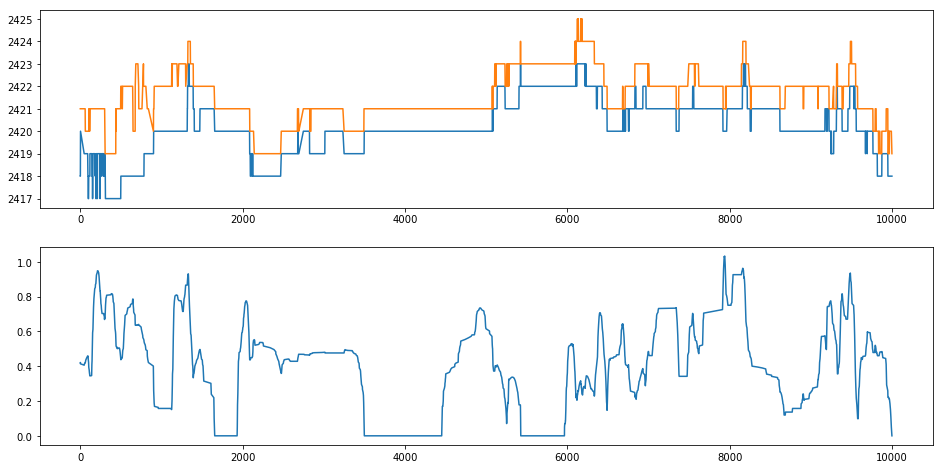

In [84]:
figsize(16, 8)

subplot(2, 1, 1)
plot(tea.BID0)
plot(tea.ASK0)

subplot(2, 1, 2)
plot(tea['Y'])